# 2018-04-26 - Améliorer le réseau
On reprend le notebook de la veille et un améliore les performances, avec notamment une séparation correcte des batchs de training et de test. Le réseau convolutionné ne convergeait pas, donc on le rétrécit en un réseau de 3 couches linéaires.

On importe les données :
                   

In [1]:
import torch
import torchvision
from torchvision import transforms, datasets

data_transform = transforms.Compose(
    [transforms.Grayscale(),
     transforms.Resize((32,32)),
    transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5,0.5), (0.5,0.5,0.5))])

train_set = datasets.ImageFolder(root='clouds_easy',
                                transform=data_transform)
train_loader = torch.utils.data.DataLoader(train_set,
                                             batch_size=4, shuffle=True,
                                             num_workers=1)

test_set = datasets.ImageFolder(root='clouds_easy_test',
                                transform=data_transform)
test_loader = torch.utils.data.DataLoader(test_set,
                                             batch_size=4,shuffle=False,
                                             num_workers=1)
#les 4 thetas qu'on essaie d'apprendre
cloud_classes = ('0', 'pi/4', 'pi/2', '3pi/4')

On affiche des images du set importé pour vérifier que tout a bien marché :

In [2]:
import matplotlib.pyplot as plt
import numpy as np


# pour montrer une image
def imshow(img):
    img = img / 2 + 0.5    #de-normaliser
    npimg = img.numpy()    #convertir en array
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# on loop sur un batch
dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('          '.join('%s' % cloud_classes[labels[j]] for j in range(4)))

pi/4          3pi/4          pi/2          0


Et maintenant on défini le réseau :

In [3]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
        def __init__(self):
            super(Net, self).__init__()
            self.fc1 = nn.Linear(32 * 32, 200)
            self.fc2 = nn.Linear(200, 200)
            self.fc3 = nn.Linear(200, 4)

        def forward(self, x):
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
            return F.log_softmax(input=x)
model = Net()
print(model)

Net(
  (fc1): Linear(in_features=1024, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=4, bias=True)
)


Et l'optimiseur, toujours en SGD mais avec un learning rate 10 fois plus grand. Avec NLLL comme critère, on a rajouté une couche de softmax en sortie pour obtenir des log-proba.

In [4]:
import torch.optim as optim

criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

On entraine :

In [5]:
import time
start_time = time.time()
print("Started training")

epochs = 50
print_interval = 50 #prints every p_i*4
tempo = []
acc = []

for epoch in range(epochs):  # nbr epochs
    for batch_idx, (data, target) in enumerate(train_loader): #nbr batch,in,out
        data, target = Variable(data), Variable(target)

        #On resize pour la sortie
        data = data.view(-1, 32*32)

        #init l'entrainement
        optimizer.zero_grad()
        net_out = model(data)
        loss = criterion(net_out, target)
        loss.backward()
        optimizer.step()

        #afficher la progression
        if batch_idx % print_interval == 0:
            #le print statement le plus illisible du monde
            print('Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch+1, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.data[0]))
    tempo.append(epoch)
    acc.append(loss.data[0])
    
print("Finished training in  %.3f seconds " % (time.time() - start_time))

Started training
Epoch: 1 [0/2000 (0%)]	Loss: 1.420514


/home/hugo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


Epoch: 1 [200/2000 (10%)]	Loss: 1.402425
Epoch: 1 [400/2000 (20%)]	Loss: 1.386590
Epoch: 1 [600/2000 (30%)]	Loss: 1.280759
Epoch: 1 [800/2000 (40%)]	Loss: 1.464157
Epoch: 1 [1000/2000 (50%)]	Loss: 1.438900
Epoch: 1 [1200/2000 (60%)]	Loss: 1.395345
Epoch: 1 [1400/2000 (70%)]	Loss: 1.331726
Epoch: 1 [1600/2000 (80%)]	Loss: 1.385785
Epoch: 1 [1800/2000 (90%)]	Loss: 1.506883
Epoch: 2 [0/2000 (0%)]	Loss: 1.388134
Epoch: 2 [200/2000 (10%)]	Loss: 1.350660
Epoch: 2 [400/2000 (20%)]	Loss: 1.381277
Epoch: 2 [600/2000 (30%)]	Loss: 1.394785
Epoch: 2 [800/2000 (40%)]	Loss: 1.431708
Epoch: 2 [1000/2000 (50%)]	Loss: 1.363331
Epoch: 2 [1200/2000 (60%)]	Loss: 1.305024
Epoch: 2 [1400/2000 (70%)]	Loss: 1.393118
Epoch: 2 [1600/2000 (80%)]	Loss: 1.460998
Epoch: 2 [1800/2000 (90%)]	Loss: 1.329283
Epoch: 3 [0/2000 (0%)]	Loss: 1.433673
Epoch: 3 [200/2000 (10%)]	Loss: 1.433547
Epoch: 3 [400/2000 (20%)]	Loss: 1.233086
Epoch: 3 [600/2000 (30%)]	Loss: 1.285923
Epoch: 3 [800/2000 (40%)]	Loss: 1.413773
Epoch: 3 [10

Epoch: 20 [1600/2000 (80%)]	Loss: 0.002066
Epoch: 20 [1800/2000 (90%)]	Loss: 0.001212
Epoch: 21 [0/2000 (0%)]	Loss: 0.000197
Epoch: 21 [200/2000 (10%)]	Loss: 0.000000
Epoch: 21 [400/2000 (20%)]	Loss: 0.000043
Epoch: 21 [600/2000 (30%)]	Loss: 0.000836
Epoch: 21 [800/2000 (40%)]	Loss: 0.003576
Epoch: 21 [1000/2000 (50%)]	Loss: 0.018436
Epoch: 21 [1200/2000 (60%)]	Loss: 0.010950
Epoch: 21 [1400/2000 (70%)]	Loss: 0.000486
Epoch: 21 [1600/2000 (80%)]	Loss: 0.009331
Epoch: 21 [1800/2000 (90%)]	Loss: 0.001520
Epoch: 22 [0/2000 (0%)]	Loss: 0.018935
Epoch: 22 [200/2000 (10%)]	Loss: 0.000406
Epoch: 22 [400/2000 (20%)]	Loss: 0.000100
Epoch: 22 [600/2000 (30%)]	Loss: 0.000080
Epoch: 22 [800/2000 (40%)]	Loss: 0.000190
Epoch: 22 [1000/2000 (50%)]	Loss: 0.585946
Epoch: 22 [1200/2000 (60%)]	Loss: 0.082623
Epoch: 22 [1400/2000 (70%)]	Loss: 0.111226
Epoch: 22 [1600/2000 (80%)]	Loss: 0.008869
Epoch: 22 [1800/2000 (90%)]	Loss: 0.019797
Epoch: 23 [0/2000 (0%)]	Loss: 0.173087
Epoch: 23 [200/2000 (10%)]	Loss

Epoch: 40 [600/2000 (30%)]	Loss: 0.000832
Epoch: 40 [800/2000 (40%)]	Loss: 0.000012
Epoch: 40 [1000/2000 (50%)]	Loss: 0.000018
Epoch: 40 [1200/2000 (60%)]	Loss: 0.000060
Epoch: 40 [1400/2000 (70%)]	Loss: 0.000066
Epoch: 40 [1600/2000 (80%)]	Loss: 0.000016
Epoch: 40 [1800/2000 (90%)]	Loss: 0.000352
Epoch: 41 [0/2000 (0%)]	Loss: 0.000067
Epoch: 41 [200/2000 (10%)]	Loss: 0.000197
Epoch: 41 [400/2000 (20%)]	Loss: 0.000128
Epoch: 41 [600/2000 (30%)]	Loss: 0.000117
Epoch: 41 [800/2000 (40%)]	Loss: 0.000002
Epoch: 41 [1000/2000 (50%)]	Loss: 0.000250
Epoch: 41 [1200/2000 (60%)]	Loss: 0.000145
Epoch: 41 [1400/2000 (70%)]	Loss: 0.000043
Epoch: 41 [1600/2000 (80%)]	Loss: 0.000009
Epoch: 41 [1800/2000 (90%)]	Loss: 0.000028
Epoch: 42 [0/2000 (0%)]	Loss: 0.000009
Epoch: 42 [200/2000 (10%)]	Loss: 0.000346
Epoch: 42 [400/2000 (20%)]	Loss: 0.000159
Epoch: 42 [600/2000 (30%)]	Loss: 0.000037
Epoch: 42 [800/2000 (40%)]	Loss: 0.000161
Epoch: 42 [1000/2000 (50%)]	Loss: 0.000081
Epoch: 42 [1200/2000 (60%)]	L

Et maintenant on teste :

In [6]:
test_loss = 0
correct = 0

for data, target in test_loader:
    data, target = Variable(data, volatile=True), Variable(target)
    
    #rescale
    data = data.view(-1, 32 * 32)
    net_out = model(data)
    
    #somme des pertes du batch
    test_loss += criterion(net_out, target).data[0]
    pred = net_out.data.max(1)[1] #prediction
    correct += pred.eq(target.data).sum() #output du réseau

test_loss /= len(test_loader.dataset) #loss = loss/length set
print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

/home/hugo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()



Test set: Average loss: 0.0200, Accuracy: 96/100 (96%)



On sauvegarde le modèle :

In [12]:
torch.save(model.state_dict(), "pytorchMCV2")

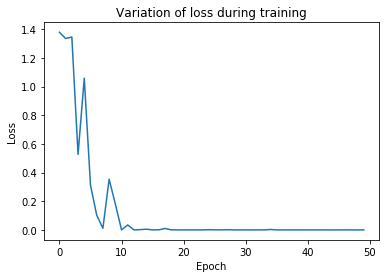

In [11]:
#joli plot du loss en fonction de l'epoch
import matplotlib.pyplot as plt
plt.plot(tempo, acc)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Variation of loss during training')
plt.show()